# Temporal MHW Trends

In [29]:
import os
import pickle
from datetime import date

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
REPO_ROOT = '/Users/rwegener/repos/chesapeake_mhw'

## Reading in the Mazzini results 😶

Translating my names to the 2 digit codes Mazini uses that denote buoy location.
* UB1 = TB (orange)
* UB2 = TP (blue)
* MB1 = LW (red)
* MB2 = SI (teal)
* LB1 = KP (tan)
* LB2 = GI (purple)

In [2]:
# starting in 2002
freq_dict = {
    'ub1': [1, 0, 1, 4, 1, 3, 1, 1, 7, 3, 6, 2, 1, 4, 5, 7, 4, 4, 6], 
    'ub2': [4, 0, 1, 3, 3, 2, 1, 1, 5, 3, 8, 3, 0, 5, 3, 5, 2, 5, 8], 
    'mb1': [4, 1, 2, 2, 2, 2, 0, 1, 2, 3, 6, 1, 1, 2, 4, 4, 5, 4, 2], 
    'mb2': [1, 0, 1, 2, 1, 3, 0, 2, 5, 2, 4, 3, 0, 3, 4, 8, 5, 3, 5], 
    'lb1': [4, 0, 0, 1, 1, 2, 0, 0, 4, 3, 4, 0, 3, 6, 1, 2, 5, 2, 5], 
    'lb2': [2, 1, 3, 5, 3, 2, 2, 0, 2, 2, 2, 0, 0, 3, 4, 5, 8, 4, 5],
      }

In [3]:
freq = pd.DataFrame(freq_dict, index=pd.to_datetime(range(2002, 2021), format='%Y'))

## Load `mhw.detect` stats output from Geopolar

### Setup

Test points:
- middle bay: `x[23, 24]`

In [4]:
# for i in range(x.shape[0]):
#     for j in range(x.shape[1]):
#         if len(x[i, j]['time_start']) > 0:
#             print('found a mhw at', i, j)

Open zones numbers for masking

In [7]:
trad_zones_rast_ds = xr.open_dataset('../../../data/chesapeake_traditional_zones.nc')
trad_zones_rast = trad_zones_rast_ds.traditional_zones

Frequency function

In [8]:
def no_annual_events(time_arr):
    '''
    counts the number of mhw in each year and returns an array with
    the number of MHW events in each year
    '''
    # getting the years from the start date
    f = lambda x: x.year
    years = np.vectorize(f, otypes=[int])(time_arr['date_start'])
    
    # count the number of events for every year from 2003 to 2021
    # don't include 2002 or 2022 because we don't have the full time series
    year_counts = np.empty(len(range(2003, 2022)))
    for i, yr in enumerate(range(2003, 2022)):
        year_counts[i] = np.count_nonzero(years == yr)
    
    # find the average number of events per year
    return year_counts

### Run the function on the full array

Open the pickled data structures from `stats_calc.ipynb`

In [12]:
with open('../../../data/avg_stats_arr0_UpperBay.pkl','rb') as f:
    avg_stats_uppbay = pickle.load(f)

In [13]:
with open('../../../data/avg_stats_arr0_MiddleBay.pkl','rb') as f:
    avg_stats_midbay = pickle.load(f)

In [14]:
with open('../../../data/avg_stats_arr0_LowerBay.pkl','rb') as f:
    avg_stats_lowbay = pickle.load(f)

[SO post](https://stackoverflow.com/questions/3379301/using-numpy-vectorize-on-functions-that-return-vectors) about generalizing `np.vectorize()` to allow for an array output. 

In [15]:
freq_sat_uppbay = np.vectorize(no_annual_events, signature='()->(n)')(avg_stats_uppbay)
freq_sat_midbay = np.vectorize(no_annual_events, signature='()->(n)')(avg_stats_midbay)
freq_sat_lowbay = np.vectorize(no_annual_events, signature='()->(n)')(avg_stats_lowbay)

### Aggregate across space

In [16]:
# masking out pixels not in this zone
freq_sat_uppbay[trad_zones_rast != 0] = np.nan
freq_sat_midbay[trad_zones_rast != 1] = np.nan
freq_sat_lowbay[trad_zones_rast != 2] = np.nan

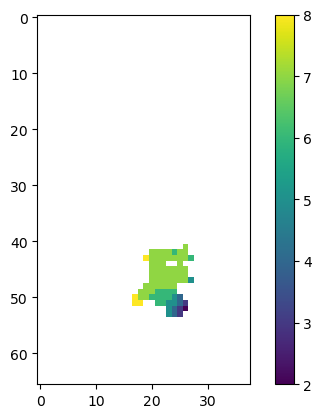

In [17]:
plt.imshow(freq_sat_uppbay[:, :, 9])
plt.colorbar()

In [18]:
freq['ub_sat'] = np.nanmean(freq_sat_uppbay, axis=(0, 1))
freq['mb_sat'] = np.nanmean(freq_sat_midbay, axis=(0, 1))
freq['lb_sat'] = np.nanmean(freq_sat_lowbay, axis=(0, 1))

## Making some nice plots

In [19]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [20]:
# plt.style.use('seaborn-talk')

In [21]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [22]:
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

Text(0.5, 1.0, 'Frequency of MHW in the Lower Bay show\nsimilar trends in buoy and satellite data')

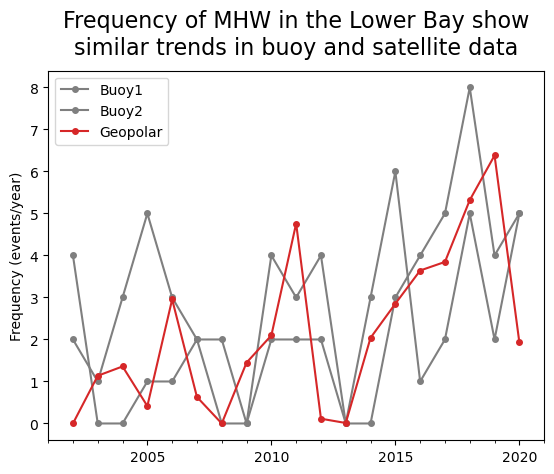

In [23]:
fig, ax = plt.subplots()

freq[['lb1', 'lb2', 'lb_sat']].plot(
    ax=ax, marker='o', markersize=4, color=[colors[7], colors[7], colors[3]],
)
ax.set_xlim([date(2001, 10, 1), date(2021, 3, 1)])

ax.set_ylabel('Frequency (events/year)')
ax.legend(['Buoy1', 'Buoy2', 'Geopolar'])
ax.set_title('Frequency of MHW in the Lower Bay show\n' 
             'similar trends in buoy and satellite data', fontsize=16, pad=12)

Text(0.5, 1.0, 'Frequency of MHW in the Middle Bay show\nsimilar trends in buoy and satellite data')

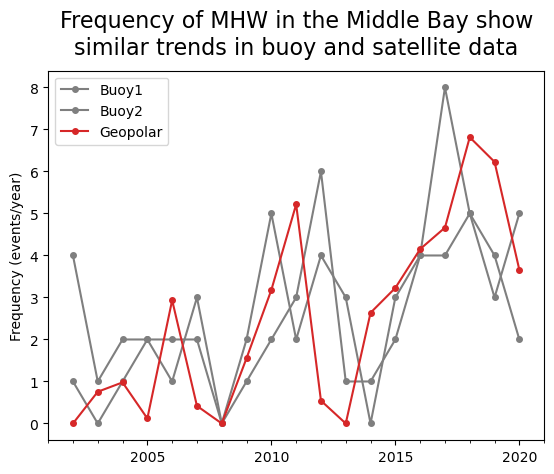

In [24]:
fig, ax = plt.subplots()

freq[['mb1', 'mb2', 'mb_sat']].plot(
    ax=ax, marker='o', markersize=4, color=[colors[7], colors[7], colors[3]],
)
ax.set_xlim([date(2001, 10, 1), date(2021, 3, 1)])

ax.set_ylabel('Frequency (events/year)')
ax.legend(['Buoy1', 'Buoy2', 'Geopolar'])
ax.set_title('Frequency of MHW in the Middle Bay show\n' 
             'similar trends in buoy and satellite data', fontsize=16, pad=12)

Text(0.5, 1.0, 'Frequency of MHW in the Upper Bay show\nsimilar trends in buoy and satellite data')

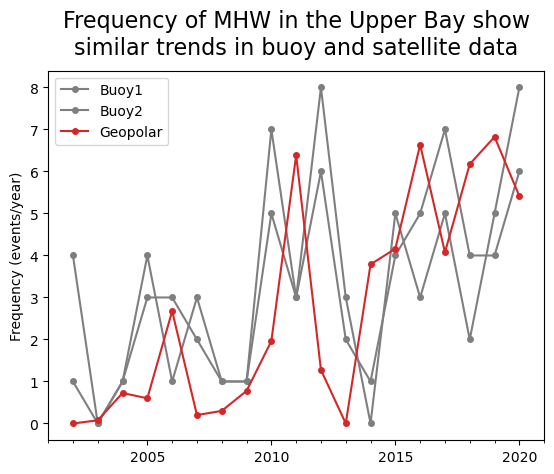

In [25]:
fig, ax = plt.subplots()

freq[['ub1', 'ub2', 'ub_sat']].plot(
    ax=ax, marker='o', markersize=4, color=[colors[7], colors[7], colors[3]],
)
ax.set_xlim([date(2001, 10, 1), date(2021, 3, 1)])

ax.set_ylabel('Frequency (events/year)')
ax.legend(['Buoy1', 'Buoy2', 'Geopolar'])
ax.set_title('Frequency of MHW in the Upper Bay show\n' 
             'similar trends in buoy and satellite data', fontsize=16, pad=12)

### Making a single plot with all 3 zones

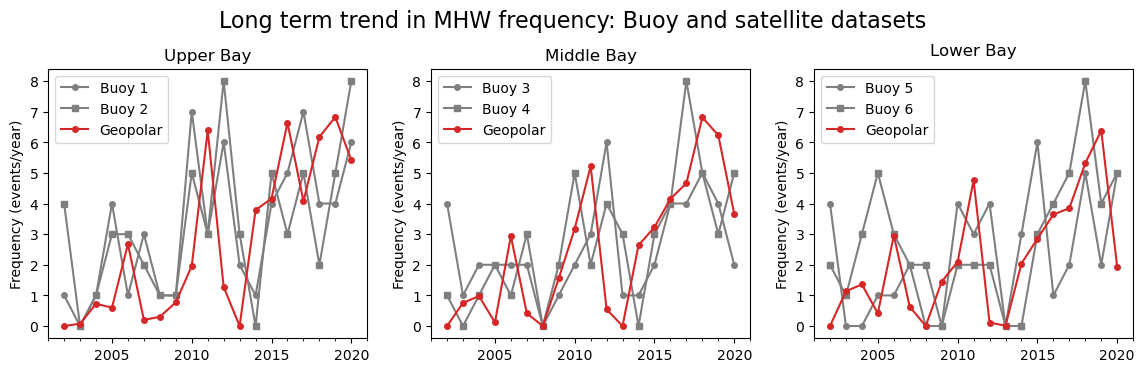

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(14, 3.5)

markers = ['-o', '-s', '-o']

# Adding data to each plot 
freq[['ub1', 'ub2', 'ub_sat']].plot(
    ax=ax1, style=markers, markersize=4, color=[colors[7], colors[7], colors[3]],  # marker='o', 
)
ax1.set_title('Upper Bay')
ax1.legend(['Buoy 1', 'Buoy 2', 'Geopolar'])

freq[['mb1', 'mb2', 'mb_sat']].plot(
    ax=ax2, style=markers, markersize=4, color=[colors[7], colors[7], colors[3]],
)
ax2.set_title('Middle Bay')
ax2.legend(['Buoy 3', 'Buoy 4', 'Geopolar'])

freq[['lb1', 'lb2', 'lb_sat']].plot(
    ax=ax3, style=markers, markersize=4, color=[colors[7], colors[7], colors[3]],
)
ax3.set_title('Lower Bay', pad=10)
ax3.legend(['Buoy 5', 'Buoy 6', 'Geopolar'])


# Setting params that are the same for all 3 plots
for ax in (ax1, ax2, ax3):
    ax.set_xlim([date(2001, 10, 1), date(2021, 3, 1)])

    ax.set_ylabel('Frequency (events/year)')

fig.suptitle('Long term trend in MHW frequency: Buoy and satellite datasets', y=1.05, 
            fontsize=16)

plt.savefig(os.path.join(REPO_ROOT, 'figures/validation_analysis', 
                         'mazzini_comparison.png'), 
            dpi=350, bbox_inches='tight')
